Due to the COVID-19 pandemic we were forced to turn to e-learning. I must admit that for me it was fun. As an academic teacher I learned a lot. We recorded videos of how to use the instruments, then I edited the video using [Shotcut](https://www.shotcut.org/). The editing was reduced to merely adding some text, speeding up some fragments, cutting and merging. But since that were laboratory classes, students should gather some data to further analyse them and produce some conclusions.

One of the classes is Geiger-Muller tube voltage calibration. During the classes students are altering Geiger-Muller counter's voltage and note how much counts does the counter record. [Some explanation](https://www.cpp.edu/~pbsiegel/bio431/texnotes/chapter4.pdf). I would add that thanks to the plateau the number of counts, does not vary that much if the voltage changes slightly during or between the measurements (for example due to power supply malfunction).

Knowing that the radioactive decay is subject to [Poisson distribution](https://physics.uwo.ca/~psimpson/radioactivedecaymanual.pdf) I generated the data using Python. Poisson distribution is a one parameter distribution where the parameter is both mean value and variance. So I took some results of previous years classes and dived into code. I do not impose the data processing way. Students are free to use any kind of software. I tried to ecourage them to use Python, R, Matlab, Scilab or whatever else there is in the world.

Well.. They all use MSExcel, so I generated so much data that it failed to read it. Scroll down to check the code and some plots.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

In [2]:
plt.style.use("dark_background")
rcParams["font.size"] = 25
rcParams["figure.figsize"] = (15,8)

In [3]:
volts = "340;420;430;440;460;500;520;540;560;580;600;620;640;660;680;700;720;740;760;780;800;820;840;860;880;900;920;940"
cnts = "0.0;0.0;0.0;277;294;306;316;259;320;356;284;257;291;316;302;304;325;360;346;369;372;425;476;519;647;761;884;1221"
voltages = [int(x) for x in volts.split(";")]
counts = [int(float(x)) for x in cnts.split(";")]
basic_data = {voltage: count for voltage, count in zip([f"{x} V" for x in voltages], counts)}
basic_data = pd.DataFrame(basic_data, index=["mean"])
basic_data

,340 V,420 V,430 V,440 V,460 V,500 V,520 V,540 V,560 V,580 V,...,760 V,780 V,800 V,820 V,840 V,860 V,880 V,900 V,920 V,940 V
mean,0,0,0,277,294,306,316,259,320,356,...,346,369,372,425,476,519,647,761,884,1221


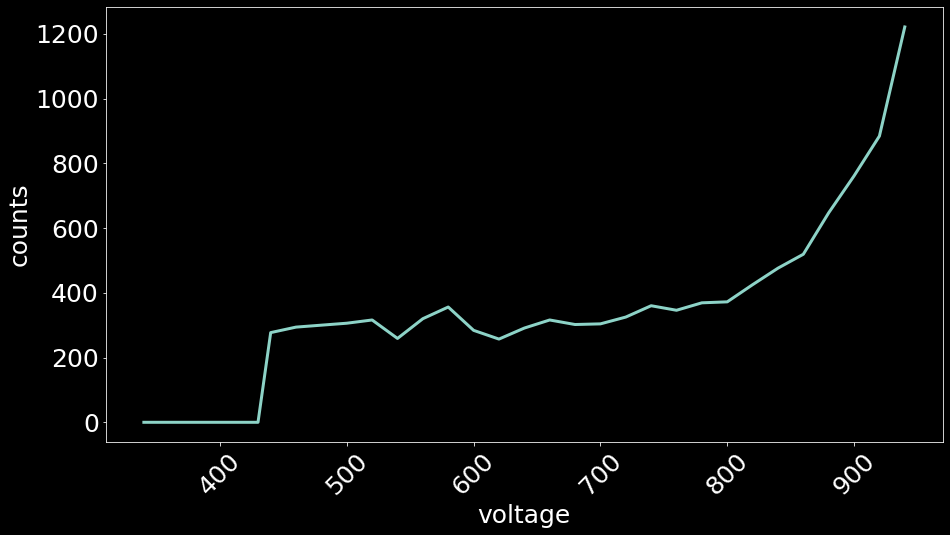

In [4]:
fig, ax = plt.subplots()
sns.lineplot(x=voltages, y=basic_data.iloc[0,:], ax=ax, linewidth=3)
ax.set(xlabel="voltage", ylabel="counts")
ax.tick_params(axis="x", rotation=45)

Well although, the data is not perfect, the plateau region is clearly visible.

In [5]:
num_measurements = 100000
pd0 = pd.DataFrame(np.zeros((num_measurements,3)))
pd1 = basic_data[basic_data.columns[3:]].apply(np.random.poisson, size=num_measurements)
data = pd.concat([pd0, pd1], axis=1)
data.columns = [f"{x} V" for x in voltages]

In [6]:
data.head()

,340 V,420 V,430 V,440 V,460 V,500 V,520 V,540 V,560 V,580 V,...,760 V,780 V,800 V,820 V,840 V,860 V,880 V,900 V,920 V,940 V
0,0.0,0.0,0.0,291,284,294,297,245,305,375,...,363,335,354,410,467,503,673,799,862,1246
1,0.0,0.0,0.0,293,323,330,321,256,320,367,...,373,350,349,420,427,482,628,723,813,1266
2,0.0,0.0,0.0,306,270,293,324,251,346,348,...,343,381,380,420,469,489,664,772,850,1227
3,0.0,0.0,0.0,256,312,314,287,273,347,320,...,366,353,365,415,489,545,640,824,880,1208
4,0.0,0.0,0.0,286,305,316,313,232,306,358,...,368,356,372,410,468,563,642,730,879,1297


In [7]:
melted_data = data.melt(var_name="Voltage [V]", value_name="Counts")

In [8]:
melted_data.head()

,Voltage [V],Counts
0,340 V,0.0
1,340 V,0.0
2,340 V,0.0
3,340 V,0.0
4,340 V,0.0


In [9]:
melted_data["Voltage [V]"] = melted_data["Voltage [V]"].apply(lambda x: int(x.split()[0]))

In [10]:
melted_data.head()

,Voltage [V],Counts
0,340,0.0
1,340,0.0
2,340,0.0
3,340,0.0
4,340,0.0


Now we can generate a plot with confidence interval. One of the goals to pass the class is to generate a plot with confidence interval and indicate what should be the optimal voltage for the G-M tube that was used during the measurements.

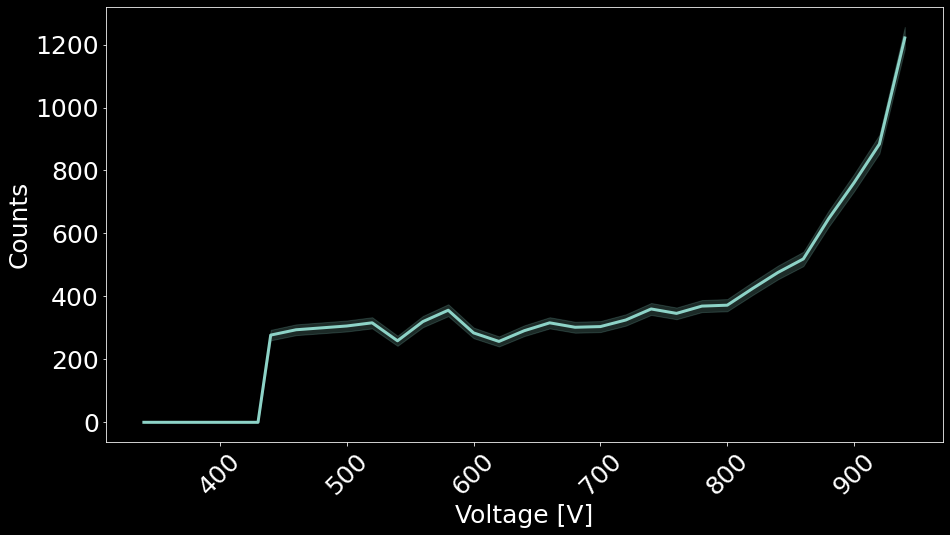

In [11]:
fig, ax = plt.subplots()
sns.lineplot(x="Voltage [V]", y="Counts", data=melted_data, ci="sd", linewidth=3)
ax.tick_params(axis="x", rotation=45)

In [12]:
data_transposed = data.T

In [13]:
data.shape, melted_data.shape, data_transposed.shape

((100000, 28), (2800000, 2), (28, 100000))

We now have the same data but organised into 3 different shapes.
1. data - 100k rows, 28 columns; this is readable in MSExcel
2. melted_data - 2.8 million rows, 2 columns; this amount of rows is not readable in MSExcel
3. data_transposed - 28 rows, 100k columns; this amount of columns is not readable in MSExcel

In [16]:
data.to_csv("data_ready.csv")  #  11.9MB
melted_data.to_csv("data2_ready.csv")  #  54.5MB
data_transposed.to_csv("data3_ready.csv")  # 16.9MB

But now, after reading [this article](https://towardsdatascience.com/csv-files-for-storage-no-thanks-theres-a-better-option-72c78a414d1d) I would use .parquet file format. To do that we must change column names of transposed data to strings. You may also need to install pyarrow or fastarrow to use parquet file format.

In [15]:
data_transposed.columns = [f"measurement_{x}" for x in range(num_measurements)]

In [16]:
data.to_parquet("data_ready.parquet")  #  2.5MB
melted_data.to_parquet("data2_ready.parquet")  #  2.8MB
data_transposed.to_parquet("data3_ready.parquet")  # 87.8MB

As you can see the transposed .parquet file takes more disk space than .csv so I would stick to .csv in this case.